In [27]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler,  OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from joblib import dump

# fetch dataset 
obesidad = fetch_ucirepo(id=544) 
  
# data (as pandas dataframes) 
X = obesidad.data.features 
y = obesidad.data.targets 

# ver tipos de datos
X.dtypes


Gender                             object
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight     object
FAVC                               object
FCVC                              float64
NCP                               float64
CAEC                               object
SMOKE                              object
CH2O                              float64
SCC                                object
FAF                               float64
TUE                               float64
CALC                               object
MTRANS                             object
dtype: object

In [28]:
# Transformación y estandarización de datos numéricos y categóricos
categorical_cols = ["Gender", "family_history_with_overweight", "FAVC", "CAEC", 
                    "SMOKE", "SCC", "CALC", "MTRANS"]
numerical_cols = ["Age", "FCVC", "NCP", "CH2O", "FAF", "TUE", "Height", "Weight"]


preprocessor = ColumnTransformer(
    transformers=[
        ("num", MinMaxScaler(), numerical_cols),
        ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_cols)  
    ],
    remainder="drop"  
)

X_processed = preprocessor.fit_transform(X)


ohe_categories = preprocessor.named_transformers_["cat"].get_feature_names_out(categorical_cols)
processed_columns = numerical_cols + list(ohe_categories)
X_processed = pd.DataFrame(X_processed, columns=processed_columns)

# vemos los primeros 5
print(X_processed.head())

        Age  FCVC       NCP  CH2O       FAF  TUE    Height    Weight  \
0  0.148936   0.5  0.666667   0.5  0.000000  0.5  0.320755  0.186567   
1  0.148936   1.0  0.666667   1.0  1.000000  0.0  0.132075  0.126866   
2  0.191489   0.5  0.666667   0.5  0.666667  0.5  0.660377  0.283582   
3  0.276596   1.0  0.666667   0.5  0.666667  0.0  0.660377  0.358209   
4  0.170213   0.5  0.000000   0.5  0.000000  0.0  0.622642  0.379104   

   Gender_Female  Gender_Male  ...  SCC_yes  CALC_Always  CALC_Frequently  \
0            1.0          0.0  ...      0.0          0.0              0.0   
1            1.0          0.0  ...      1.0          0.0              0.0   
2            0.0          1.0  ...      0.0          0.0              1.0   
3            0.0          1.0  ...      0.0          0.0              1.0   
4            0.0          1.0  ...      0.0          0.0              0.0   

   CALC_Sometimes  CALC_no  MTRANS_Automobile  MTRANS_Bike  MTRANS_Motorbike  \
0             0.0      1

In [29]:
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt

def optimise_k_medoids(data, max_k, metric='manhattan'):

    clusters = []
    costs = []
    
    for k in range(1, max_k):
        kmedoids = KMedoids(n_clusters=k, metric=metric, random_state=42)
        kmedoids.fit(data)
        clusters.append(k)
        costs.append(kmedoids.inertia_)  # costo total equivalente

    # gráfica de los resultados
    plt.figure(figsize=(10, 5))
    plt.plot(clusters, costs, 'o-')
    plt.xlabel("Number of Clusters")
    plt.ylabel("Cost Total (Dissimilarity)")
    plt.title(f"KMedoids Optimization ({metric.capitalize()} Distance)")
    plt.grid(True)
    plt.show()


c:\Users\juell\.conda\envs\Obesidad\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 12 is empty! self.labels_[self.medoid_indices_[12]] may not be labeled with its corresponding cluster (12).
  warnings.warn(
c:\Users\juell\.conda\envs\Obesidad\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 12 is empty! self.labels_[self.medoid_indices_[12]] may not be labeled with its corresponding cluster (12).
  warnings.warn(


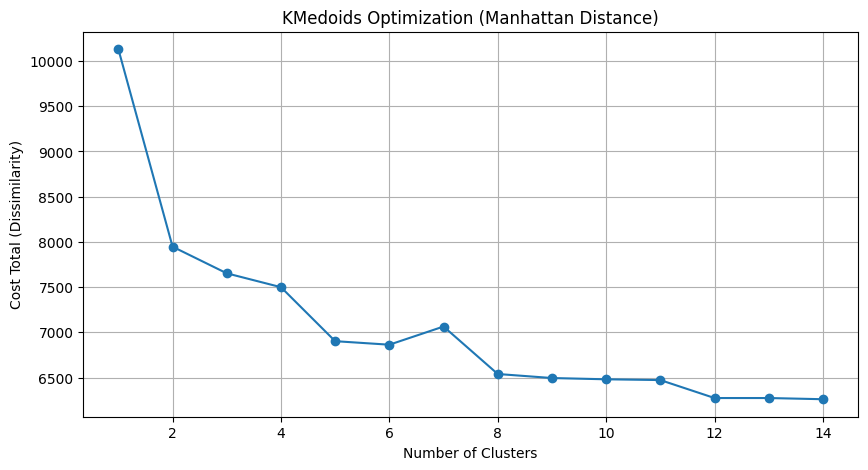

In [30]:
optimise_k_medoids(X_processed, 15)

In [31]:
from sklearn_extra.cluster import KMedoids
n_clusters = 5

kmedoids = KMedoids(n_clusters=n_clusters, metric="manhattan", random_state=42)
kmedoids.fit(X_processed)

labels = kmedoids.labels_

X_processed['K_Medoids_5'] = labels
X_processed

,Age,FCVC,NCP,CH2O,FAF,TUE,Height,Weight,Gender_Female,Gender_Male,...,CALC_Always,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking,K_Medoids_5
0,0.148936,0.5,0.666667,0.500000,0.000000,0.500000,0.320755,0.186567,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,3
1,0.148936,1.0,0.666667,1.000000,1.000000,0.000000,0.132075,0.126866,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,3
2,0.191489,0.5,0.666667,0.500000,0.666667,0.500000,0.660377,0.283582,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
3,0.276596,1.0,0.666667,0.500000,0.666667,0.000000,0.660377,0.358209,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
4,0.170213,0.5,0.000000,0.500000,0.000000,0.000000,0.622642,0.379104,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,0.148443,1.0,0.666667,0.364070,0.558756,0.453124,0.491943,0.689616,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,4
2107,0.169850,1.0,0.666667,0.502565,0.447130,0.299635,0.563366,0.707037,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,4
2108,0.181362,1.0,0.666667,0.527097,0.471403,0.323144,0.570200,0.706637,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,4
2109,0.220467,1.0,0.666667,0.926170,0.379702,0.293017,0.546132,0.704079,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,4


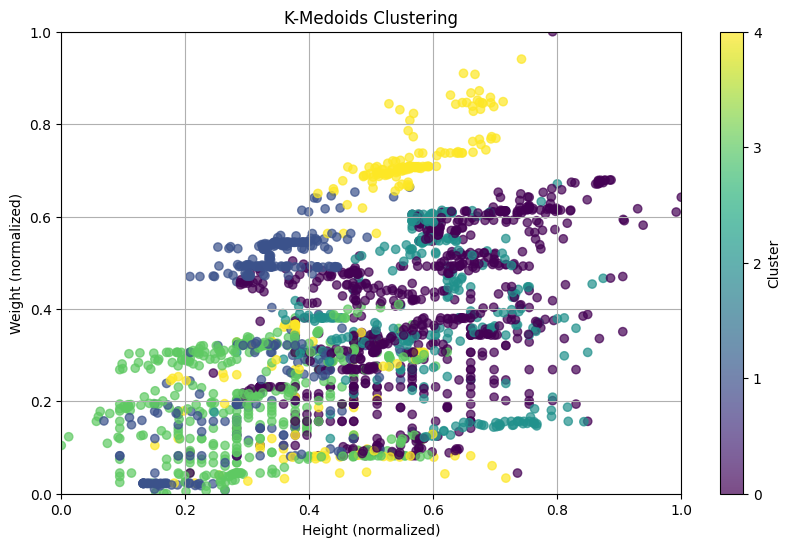

In [32]:
plt.figure(figsize=(10, 6))


scatter = plt.scatter(
    x=X_processed['Height'],
    y=X_processed['Weight'],
    c=X_processed['K_Medoids_5'],
    cmap='viridis',
    alpha=0.7
)


plt.xlim(0, 1)
plt.ylim(0, 1)


plt.title('K-Medoids Clustering')
plt.xlabel('Height (normalized)')
plt.ylabel('Weight (normalized)')


cbar = plt.colorbar(scatter)
cbar.set_label('Cluster')
cbar.set_ticks([0, 1, 2, 3, 4])  
cbar.set_ticklabels(['0', '1', '2', '3', '4'])

plt.grid(True)
plt.show()




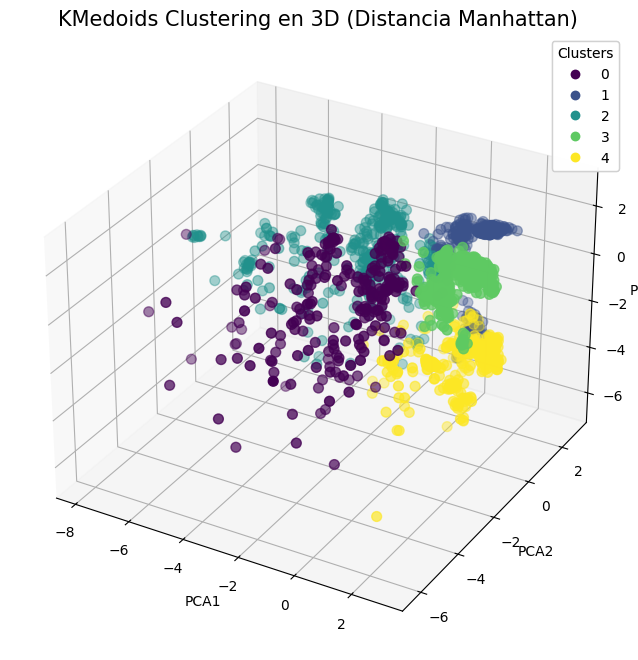

In [33]:
from sklearn.decomposition import PCA
from sklearn_extra.cluster import KMedoids
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler

# reducción a 3D con PCA para mejor visualización
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_processed)


pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)


n_clusters = 5


kmedoids = KMedoids(n_clusters=n_clusters, metric="manhattan", random_state=42)
kmedoids.fit(X_pca)

labels = kmedoids.labels_

# añadir etiquetas
X_pca_df = pd.DataFrame(X_pca, columns=["PCA1", "PCA2", "PCA3"])
X_pca_df["Cluster"] = labels

# gráfico 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')


scatter = ax.scatter(X_pca_df["PCA1"], X_pca_df["PCA2"], X_pca_df["PCA3"], c=X_pca_df["Cluster"], cmap='viridis', s=50)

ax.set_title('KMedoids Clustering en 3D (Distancia Manhattan)', fontsize=15)
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')

legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.show()


## PCA - Análisis de componentes principales

Se genera un análisis de componentes principales sin tener en cuenta las variables altura y peso, ya que estas explican los niveles de obesidad en alta medida. Tampoco se toman en cuentan las variables categóricas.

In [34]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler,  OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from joblib import dump

# fetch dataset 
obesidad = fetch_ucirepo(id=544) 
  
# data (as pandas dataframes) 
X = obesidad.data.features 
y = obesidad.data.targets 

# añadir columna IMC

X["IMC"] = X["Weight"] / (X["Height"] ** 2)

# eliminar las columnas 'Height' y 'Weight' de X
X = X.drop(columns=["Height", "Weight"])

X.dtypes

Gender                             object
Age                               float64
family_history_with_overweight     object
FAVC                               object
FCVC                              float64
NCP                               float64
CAEC                               object
SMOKE                              object
CH2O                              float64
SCC                                object
FAF                               float64
TUE                               float64
CALC                               object
MTRANS                             object
IMC                               float64
dtype: object

In [38]:
# Columnas numéricas y binarias
numerical_cols = ["Age", "FCVC", "NCP", "CH2O", "FAF", "TUE", "IMC"]
binary_cols = ["family_history_with_overweight", "FAVC", "SMOKE", "SCC"]


preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_cols),  # Escalar numéricas
        ("cat", OneHotEncoder(drop="first"), binary_cols),  # OHE para binarias
    ],
    remainder="drop"  
)


X_preprocessed = preprocessor.fit_transform(X)


feature_names = (
    numerical_cols
    + preprocessor.named_transformers_["cat"].get_feature_names_out(binary_cols).tolist()
)

X_final = pd.DataFrame(X_preprocessed, columns=feature_names)

print(X_final.head())

        Age      FCVC       NCP      CH2O       FAF       TUE       IMC  \
0 -0.522124 -0.785019  0.404153 -0.013073 -1.188039  0.561997 -0.663421   
1 -0.522124  1.088342  0.404153  1.618759  2.339750 -1.080625 -0.681937   
2 -0.206889 -0.785019  0.404153 -0.013073  1.163820  0.561997 -0.740967   
3  0.423582  1.088342  0.404153 -0.013073  1.163820 -1.080625 -0.355619   
4 -0.364507 -0.785019 -2.167023 -0.013073 -1.188039 -1.080625 -0.169522   

   family_history_with_overweight_yes  FAVC_yes  SMOKE_yes  SCC_yes  
0                                 1.0       0.0        0.0      0.0  
1                                 1.0       0.0        1.0      1.0  
2                                 1.0       0.0        0.0      0.0  
3                                 0.0       0.0        0.0      0.0  
4                                 0.0       0.0        0.0      0.0  


In [37]:
correlaciones = X_final.corr()

# correlaciones con IMC
print(correlaciones["IMC"])

Age                                   0.244163
FCVC                                  0.263651
NCP                                   0.039969
CH2O                                  0.144200
FAF                                  -0.177537
TUE                                  -0.099720
IMC                                   1.000000
family_history_with_overweight_yes    0.483508
FAVC_yes                              0.246097
SMOKE_yes                            -0.000819
SCC_yes                              -0.184286
Name: IMC, dtype: float64


  Componente  Varianza Explicada  Varianza Acumulada
0        PC1            0.220587            0.220587
1        PC2            0.179600            0.400187
2        PC3            0.138780            0.538967
3        PC4            0.129108            0.668075
4        PC5            0.123596            0.791670


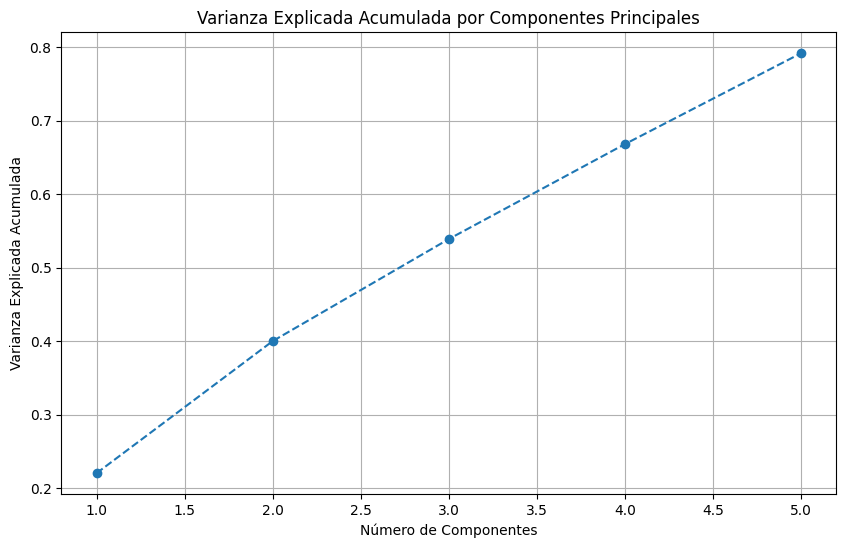

In [22]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Aplicar PCA a los datos escalados
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_final)  # X_final es el DataFrame con las columnas numéricas escaladas

# Ver la varianza explicada por cada componente
explained_variance = pca.explained_variance_ratio_

# Calcular la varianza explicada acumulada
cumulative_variance = explained_variance.cumsum()

# Crear un DataFrame para mostrar la varianza explicada y acumulada de manera bonita
variance_df = pd.DataFrame({
    'Componente': [f'PC{i+1}' for i in range(len(explained_variance))],
    'Varianza Explicada': explained_variance,
    'Varianza Acumulada': cumulative_variance
})

# Mostrar la tabla de varianza explicada y acumulada
print(variance_df)

# Visualizar la varianza explicada acumulada
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Varianza Explicada Acumulada por Componentes Principales')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Explicada Acumulada')
plt.grid(True)
plt.show()



## MODELO DE ML: GRADIENT BOOSTING

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report


X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

gb_model = GradientBoostingClassifier(n_estimators=200, random_state=42)

gb_model.fit(X_train, y_train)

y_pred = gb_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print("\nClassification Report:")
print(report)


c:\Users\juell\.conda\envs\Obesidad\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.7541

Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.74      0.75      0.74        56
      Normal_Weight       0.62      0.60      0.61        62
     Obesity_Type_I       0.73      0.81      0.77        78
    Obesity_Type_II       0.89      0.88      0.89        58
   Obesity_Type_III       0.98      0.97      0.98        63
 Overweight_Level_I       0.67      0.70      0.68        56
Overweight_Level_II       0.60      0.52      0.56        50

           accuracy                           0.75       423
          macro avg       0.75      0.75      0.75       423
       weighted avg       0.75      0.75      0.75       423



In [40]:
# Guardamos el pipeline completo (preprocesamiento + modelo entrenado)
import joblib
joblib.dump(gb_model,'../Modelos/GB_Model')

['../Modelos/GB_Model']

## OPTIMIZACIÓN DE HIPERPARÁMETROS

In [41]:
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

gb_model = GradientBoostingClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 150, 200],  
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  
    'max_depth': [2, 5, 10] 
}

grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)

print(f"Mejores parámetros: {grid_search.best_params_}")

y_pred = grid_search.best_estimator_.predict(X_test)

# evaluamos el modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Users\juell\.conda\envs\Obesidad\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mejores parámetros: {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 150}
Accuracy: 0.7683

Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.75      0.77      0.76        56
      Normal_Weight       0.61      0.58      0.60        62
     Obesity_Type_I       0.78      0.79      0.78        78
    Obesity_Type_II       0.88      0.90      0.89        58
   Obesity_Type_III       0.98      0.97      0.98        63
 Overweight_Level_I       0.64      0.70      0.67        56
Overweight_Level_II       0.71      0.64      0.67        50

           accuracy                           0.77       423
          macro avg       0.77      0.76      0.76       423
       weighted avg       0.77      0.77      0.77       423

